# 특수코드 처리 전략 및 데이터 정제

응답거부, 모름, 비해당 등 특수코드를 체계적으로 처리합니다.

In [1]:
import sys
import os

# 프로젝트 루트를 Python 경로에 추가
project_root = os.path.abspath('../../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 폰트 설정 (팀 통일)
try:
    font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False

# 팀 컬러
TEAM_COLORS = {
    'primary': '#1f77b4',
    'success': '#ff7f0e',
    'danger': '#1f77b4',
    'palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
}

# 데이터 로드
df = pd.read_csv('../../../data/analy_data.csv')
print(f"원본 데이터: {len(df):,}건")
print(f"전체 금연 성공률: {df['churn'].mean()*100:.2f}%")

원본 데이터: 89,822건
전체 금연 성공률: 54.83%


## 1. 특수코드 현황 파악

In [2]:
# 변수별 특수코드 정의
special_codes_map = {
    'sob_01z1': {'응답거부': 77, '모름': 99},
    'sob_02z1': {'응답거부': 7, '비해당': 8, '모름': 9},
    'soa_01z1': {'응답거부': 7, '모름': 9},
    'soa_06z2': {'응답거부': 77, '비해당': 88, '모름': 99},
    'soa_07z1': {'응답거부': 7, '비해당': 8, '모름': 9},
    'sod_02z3': {'응답거부': 7, '모름': 9}
}

print("="*80)
print("📊 변수별 특수코드 현황")
print("="*80)

special_summary = []

for var, codes in special_codes_map.items():
    print(f"\n### {var}")
    var_total = 0
    
    for label, code in codes.items():
        count = (df[var] == code).sum()
        pct = count / len(df) * 100
        var_total += count
        print(f"  {label:10} (코드 {code:2}): {count:6,}건 ({pct:5.2f}%)")
        
        special_summary.append({
            '변수': var,
            '특수코드': label,
            '코드값': code,
            '건수': count,
            '비율(%)': f"{pct:.2f}"
        })
    
    print(f"  {'[합계]':10}        : {var_total:6,}건 ({var_total/len(df)*100:5.2f}%)")

special_df = pd.DataFrame(special_summary)
print("\n" + "="*80)
print(special_df.to_string(index=False))

📊 변수별 특수코드 현황

### sob_01z1
  응답거부       (코드 77):     33건 ( 0.04%)
  모름         (코드 99):      1건 ( 0.00%)
  [합계]              :     34건 ( 0.04%)

### sob_02z1
  응답거부       (코드  7):     33건 ( 0.04%)
  비해당        (코드  8):  1,519건 ( 1.69%)
  모름         (코드  9):      1건 ( 0.00%)
  [합계]              :  1,553건 ( 1.73%)

### soa_01z1
  응답거부       (코드  7):      1건 ( 0.00%)
  모름         (코드  9):      3건 ( 0.00%)
  [합계]              :      4건 ( 0.00%)

### soa_06z2
  응답거부       (코드 77):      9건 ( 0.01%)
  비해당        (코드 88): 24,995건 (27.83%)
  모름         (코드 99):      4건 ( 0.00%)
  [합계]              : 25,008건 (27.84%)

### soa_07z1
  응답거부       (코드  7):      9건 ( 0.01%)
  비해당        (코드  8): 24,995건 (27.83%)
  모름         (코드  9):      4건 ( 0.00%)
  [합계]              : 25,008건 (27.84%)

### sod_02z3
  응답거부       (코드  7):     15건 ( 0.02%)
  모름         (코드  9):      2건 ( 0.00%)
  [합계]              :     17건 ( 0.02%)

      변수 특수코드  코드값    건수 비율(%)
sob_01z1 응답거부   77    33  0.04
sob_01z1   모름   99  

## 2. 처리 전략 수립

In [3]:
print("\n" + "="*80)
print("🎯 특수코드 처리 전략")
print("="*80)

print("""
### 전략 1: 응답거부 / 모름 → 무조건 제거 ✅
  - 이유: 비율이 극히 낮음 (0.0~0.1%)
  - 영향: 통계적으로 미미
  - 변수: 모든 변수 적용

### 전략 2: 비해당 처리 → 변수별 차별화 ⚠️

  A) sob_02z1 (졸업여부) - 비해당 4.3%
     → 처리: 제거
     → 이유: 재학/휴학생의 경우, 표본 손실 수용 가능
  
  B) soa_06z2, soa_07z1 (직업/종사상지위) - 비해당 35.6%
     → 처리: 별도 카테고리 유지 "비경제활동인구"
     → 이유: 
        * 35.6% 제거시 표본 손실 너무 큼
        * "비경제활동"은 의미 있는 분석 대상
        * 실업자, 주부, 학생, 은퇴자 등 포함

### 전략 3: 결측값(NaN) → 제거
  - churn이 없는 경우도 제거
""")

print("="*80)


🎯 특수코드 처리 전략

### 전략 1: 응답거부 / 모름 → 무조건 제거 ✅
  - 이유: 비율이 극히 낮음 (0.0~0.1%)
  - 영향: 통계적으로 미미
  - 변수: 모든 변수 적용

### 전략 2: 비해당 처리 → 변수별 차별화 ⚠️

  A) sob_02z1 (졸업여부) - 비해당 4.3%
     → 처리: 제거
     → 이유: 재학/휴학생의 경우, 표본 손실 수용 가능

  B) soa_06z2, soa_07z1 (직업/종사상지위) - 비해당 35.6%
     → 처리: 별도 카테고리 유지 "비경제활동인구"
     → 이유: 
        * 35.6% 제거시 표본 손실 너무 큼
        * "비경제활동"은 의미 있는 분석 대상
        * 실업자, 주부, 학생, 은퇴자 등 포함

### 전략 3: 결측값(NaN) → 제거
  - churn이 없는 경우도 제거



## 3. 데이터 정제 실행

In [4]:
# 원본 백업
df_original = df.copy()
df_clean = df.copy()

print("="*80)
print("🔧 데이터 정제 진행")
print("="*80)

# Step 0: churn 결측값 제거
df_clean = df_clean[df_clean['churn'].notna()]
print(f"\nStep 0: churn 결측값 제거")
print(f"  제거 전: {len(df_original):,}건")
print(f"  제거 후: {len(df_clean):,}건")
print(f"  제거량: {len(df_original) - len(df_clean):,}건")

# Step 1: 응답거부/모름 제거
print(f"\nStep 1: 응답거부/모름 제거")
before_count = len(df_clean)

for var, codes in special_codes_map.items():
    for label, code in codes.items():
        if label in ['응답거부', '모름']:
            removed = (df_clean[var] == code).sum()
            df_clean = df_clean[df_clean[var] != code]
            if removed > 0:
                print(f"  {var} - {label}({code}): {removed:,}건 제거")

print(f"  총 제거: {before_count - len(df_clean):,}건")
print(f"  현재 데이터: {len(df_clean):,}건")

# Step 2: sob_02z1 비해당 제거
print(f"\nStep 2: sob_02z1 (졸업여부) 비해당 제거")
before_count = len(df_clean)
df_clean = df_clean[df_clean['sob_02z1'] != 8]
print(f"  제거: {before_count - len(df_clean):,}건")
print(f"  현재 데이터: {len(df_clean):,}건")

# Step 3: soa_06z2, soa_07z1 비해당 → 그대로 유지 (재분류는 다음 단계에서)
print(f"\nStep 3: soa_06z2, soa_07z1 비해당 처리")
print(f"  처리 방법: 별도 카테고리로 유지 (제거하지 않음)")
non_econ_count = (df_clean['soa_06z2'] == 88).sum()
print(f"  비경제활동인구: {non_econ_count:,}건 ({non_econ_count/len(df_clean)*100:.1f}%)")

# Step 4: 나머지 결측값 제거
print(f"\nStep 4: 나머지 결측값 제거")
before_count = len(df_clean)
analysis_vars = ['sob_01z1', 'sob_02z1', 'soa_01z1', 'soa_06z2', 'soa_07z1', 'sod_02z3']
df_clean = df_clean.dropna(subset=analysis_vars)
print(f"  제거: {before_count - len(df_clean):,}건")
print(f"  현재 데이터: {len(df_clean):,}건")

print("\n" + "="*80)
print("✅ 데이터 정제 완료")
print("="*80)
print(f"\n원본 데이터:   {len(df_original):,}건")
print(f"정제 데이터:   {len(df_clean):,}건")
print(f"제거된 데이터: {len(df_original) - len(df_clean):,}건 ({(len(df_original) - len(df_clean))/len(df_original)*100:.1f}%)")
print(f"\n금연 성공률 (원본): {df_original['churn'].mean()*100:.2f}%")
print(f"금연 성공률 (정제): {df_clean['churn'].mean()*100:.2f}%")

🔧 데이터 정제 진행

Step 0: churn 결측값 제거
  제거 전: 89,822건
  제거 후: 89,822건
  제거량: 0건

Step 1: 응답거부/모름 제거
  sob_01z1 - 응답거부(77): 33건 제거
  sob_01z1 - 모름(99): 1건 제거
  soa_01z1 - 응답거부(7): 1건 제거
  soa_01z1 - 모름(9): 3건 제거
  soa_06z2 - 응답거부(77): 8건 제거
  soa_06z2 - 모름(99): 1건 제거
  soa_07z1 - 응답거부(7): 1건 제거
  soa_07z1 - 모름(9): 1건 제거
  sod_02z3 - 응답거부(7): 14건 제거
  sod_02z3 - 모름(9): 2건 제거
  총 제거: 65건
  현재 데이터: 89,757건

Step 2: sob_02z1 (졸업여부) 비해당 제거
  제거: 1,517건
  현재 데이터: 88,240건

Step 3: soa_06z2, soa_07z1 비해당 처리
  처리 방법: 별도 카테고리로 유지 (제거하지 않음)
  비경제활동인구: 23,981건 (27.2%)

Step 4: 나머지 결측값 제거
  제거: 0건
  현재 데이터: 88,240건

✅ 데이터 정제 완료

원본 데이터:   89,822건
정제 데이터:   88,240건
제거된 데이터: 1,582건 (1.8%)

금연 성공률 (원본): 54.83%
금연 성공률 (정제): 54.58%


## 4. 정제 전후 비교

In [5]:
# 변수별 유효 표본 비교
print("\n📊 변수별 유효 표본 비교")
print("="*80)

comparison = []
for var in analysis_vars:
    original_valid = df_original[var].notna().sum()
    cleaned_valid = df_clean[var].notna().sum()
    
    comparison.append({
        '변수': var,
        '원본 유효': f"{original_valid:,}",
        '정제 유효': f"{cleaned_valid:,}",
        '변화율': f"{(cleaned_valid - original_valid) / original_valid * 100:+.1f}%"
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))


📊 변수별 유효 표본 비교
      변수  원본 유효  정제 유효   변화율
sob_01z1 89,822 88,240 -1.8%
sob_02z1 89,822 88,240 -1.8%
soa_01z1 89,822 88,240 -1.8%
soa_06z2 89,822 88,240 -1.8%
soa_07z1 89,822 88,240 -1.8%
sod_02z3 89,822 88,240 -1.8%


## 5. 정제 데이터 저장

In [9]:
# 정제된 데이터 저장
output_path = '../output/analy_data_cleaned.csv'
df_clean.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n✅ 정제 데이터 저장 완료")
print(f"   파일: {output_path}")
print(f"   데이터: {len(df_clean):,}건")
print(f"\n💡 이제 이 데이터로 분석을 진행하세요!")


✅ 정제 데이터 저장 완료
   파일: ../output/analy_data_cleaned.csv
   데이터: 88,240건

💡 이제 이 데이터로 분석을 진행하세요!


## 6. 시각화: 정제 전후 비교

✅ variable.csv 로드 완료: 709 개 매핑
✅ variable_full.csv 로드 완료: 681 개 매핑 (fallback)
✅ variable.csv 로드 완료: 709 개 매핑
✅ variable_full.csv 로드 완료: 681 개 매핑 (fallback)


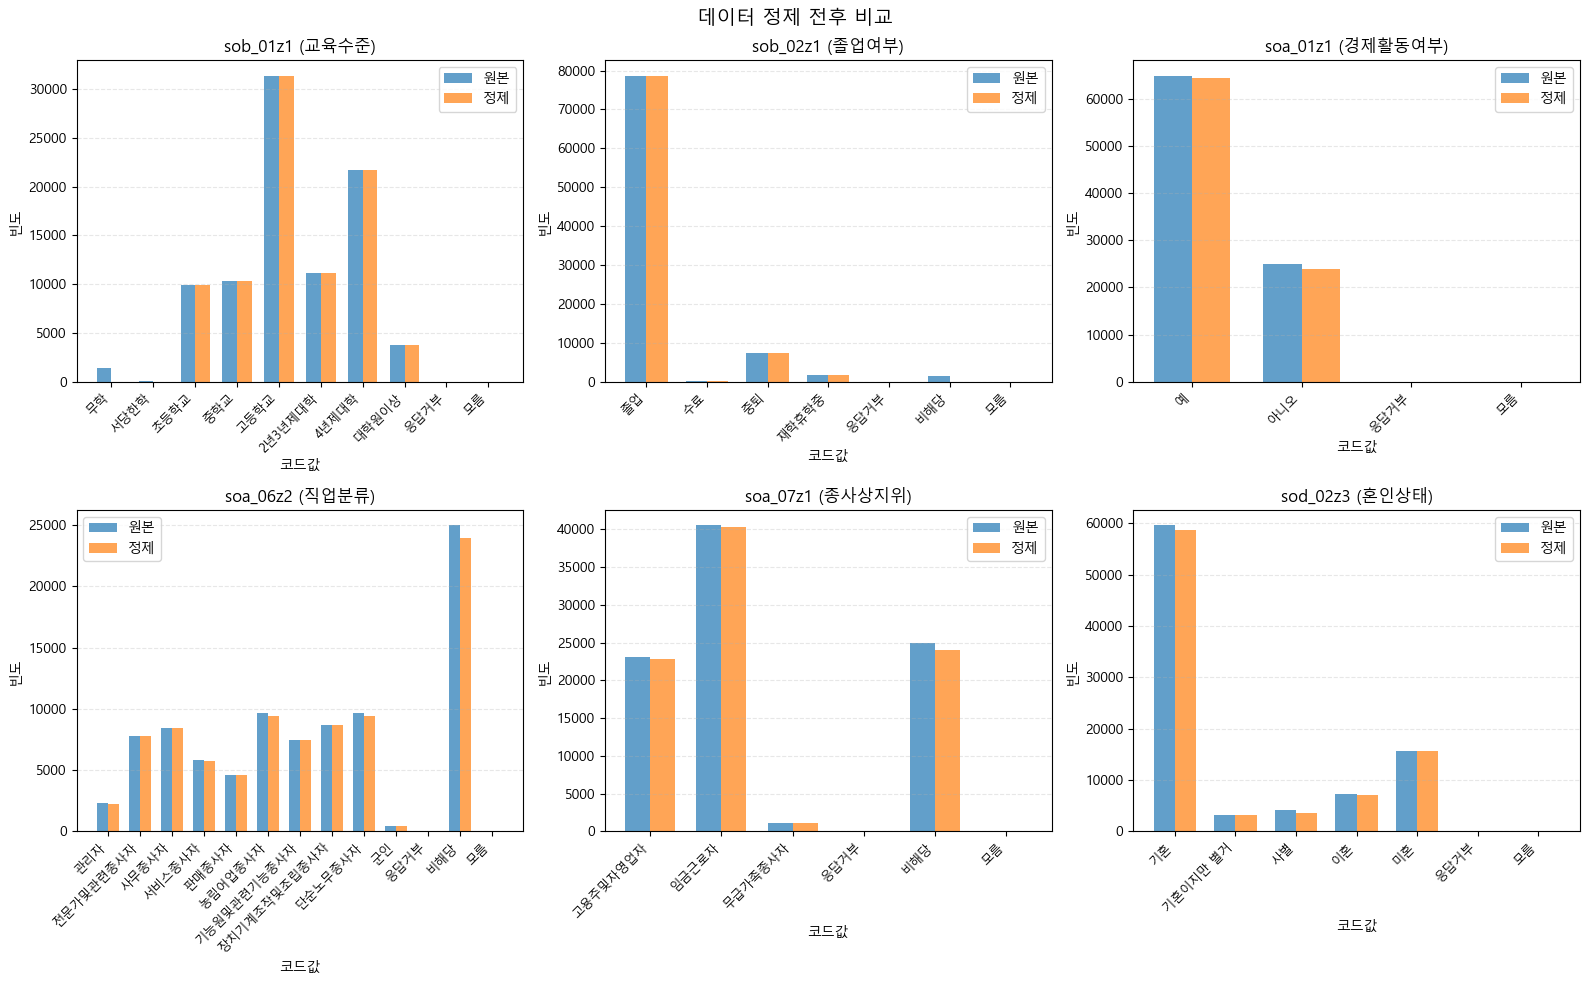

In [7]:
# Variable Decoder import
from notebooks.vfxpedia.utils.variable_decoder import VariableDecoder, get_korean_label
decoder = VariableDecoder()

# 팀 통일 스타일로 시각화 (한글 라벨링)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('데이터 정제 전후 비교', fontsize=14)

for idx, var in enumerate(analysis_vars):
    ax = axes[idx // 3, idx % 3]
    
    # 원본 vs 정제 데이터 분포
    original_counts = df_original[var].value_counts().sort_index()
    cleaned_counts = df_clean[var].value_counts().sort_index()
    
    # 🔧 FIX: 두 데이터를 같은 인덱스로 정렬 (크기 불일치 해결)
    all_codes = sorted(set(original_counts.index) | set(cleaned_counts.index))
    original_aligned = [original_counts.get(code, 0) for code in all_codes]
    cleaned_aligned = [cleaned_counts.get(code, 0) for code in all_codes]
    
    x = np.arange(len(all_codes))
    width = 0.35
    
    # 팀 컬러 사용
    ax.bar(x - width/2, original_aligned, width, 
           label='원본', alpha=0.7, color=TEAM_COLORS['danger'])
    ax.bar(x + width/2, cleaned_aligned, width, 
           label='정제', alpha=0.7, color=TEAM_COLORS['success'])
    
    # 📝 변수명 한글화 (with_var 형식: "변수명 (한글)")
    var_label = get_korean_label(var)
    title = f"{var} ({var_label})" if var_label != var else var
    ax.set_title(title, fontsize=12)
    
    ax.set_xlabel('코드값', fontsize=10)
    ax.set_ylabel('빈도', fontsize=10)
    
    # 🎨 x축 라벨 한글화 (코드 → 의미)
    korean_labels = [decoder.decode_value(var, code) for code in all_codes]
    ax.set_xticks(x)
    ax.set_xticklabels(korean_labels, rotation=45, ha='right', fontsize=9)
    
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 최종 권장사항

In [8]:
print("\n" + "="*80)
print("📋 최종 권장사항")
print("="*80)

print("""
### ✅ 앞으로의 분석은 정제 데이터(analy_data_cleaned.csv) 사용

### 🎯 주요 결정 사항:

1. **제거한 특수코드**:
   - 응답거부 (모든 변수)
   - 모름 (모든 변수)
   - sob_02z1의 비해당

2. **유지한 특수코드**:
   - soa_06z2, soa_07z1의 비해당 (코드 88, 8)
   - 이유: 비경제활동인구는 분석 대상으로 의미 있음
   - 해석: "비경제활동" 카테고리로 취급

### 💡 분석 시 유의사항:

1. soa_06z2 = 88 → "비경제활동인구"로 라벨링
2. soa_07z1 = 8  → "비경제활동"으로 라벨링
3. 이 그룹의 금연 성공률도 함께 비교 분석
4. "경제활동 여부가 금연 성공에 미치는 영향" 해석 시 중요

### 📊 다음 단계:

1. analy_data_cleaned.csv로 상관관계 분석
2. 특성 중요도 분석
3. 가설 검증
4. 최종 보고서 작성
""")

print("="*80)


📋 최종 권장사항

### ✅ 앞으로의 분석은 정제 데이터(analy_data_cleaned.csv) 사용

### 🎯 주요 결정 사항:

1. **제거한 특수코드**:
   - 응답거부 (모든 변수)
   - 모름 (모든 변수)
   - sob_02z1의 비해당

2. **유지한 특수코드**:
   - soa_06z2, soa_07z1의 비해당 (코드 88, 8)
   - 이유: 비경제활동인구는 분석 대상으로 의미 있음
   - 해석: "비경제활동" 카테고리로 취급

### 💡 분석 시 유의사항:

1. soa_06z2 = 88 → "비경제활동인구"로 라벨링
2. soa_07z1 = 8  → "비경제활동"으로 라벨링
3. 이 그룹의 금연 성공률도 함께 비교 분석
4. "경제활동 여부가 금연 성공에 미치는 영향" 해석 시 중요

### 📊 다음 단계:

1. analy_data_cleaned.csv로 상관관계 분석
2. 특성 중요도 분석
3. 가설 검증
4. 최종 보고서 작성

